In [34]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split

In [35]:
class DataGenerator:
    def __init__(
        self,
        choice_probability: list[float] = [0.75, 0.2, 0.05],
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.choice_probability = choice_probability
        self.total_panel = total_panel
        self.choices = np.fromiter(range(len(choice_probability)), dtype=int)
        self.is_treatment_group = not control_group
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.random.choice(a = self.choices, size = (n_samples, self.total_panel), p = self.choice_probability)
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [36]:
c_gen = DataGenerator(
    choice_probability= [0.5, 0.45, 0.05],
    total_panel = 20,
    control_group = True
)
c_data = c_gen.generate_data(n_samples=100, n_surrogates=20)

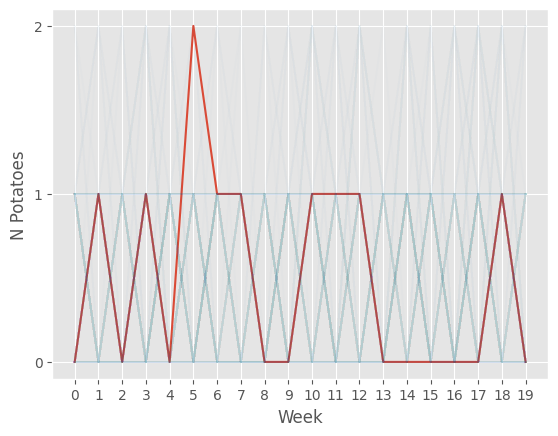

In [37]:
plot_data = (
    c_data
    .assign(user_id = range(c_data.shape[0]))
    .melt(
        id_vars = ['user_id'],
        value_vars = [f"surrogate_{i}" for i in range(c_gen.total_panel)]
    )
    .assign(
        n_surrogate = lambda df: df.loc[:, 'variable'].map(lambda s: int(s.split('_')[-1]))
    )
)

fig, ax = plt.subplots()
sns.lineplot(
    data = plot_data.query('user_id == 0'),
    x = 'n_surrogate',
    y = 'value',
    ax = ax
)
sns.lineplot(
    data = plot_data,
    x = 'n_surrogate',
    y = 'value',
    units = 'user_id',
    estimator = None,
    ax = ax,
    alpha = 0.01,
)
_ = ax.set_xticks(range(c_gen.total_panel))
_ = ax.set_yticks(range(0, 3))
_ = ax.set_xlabel('Week')
_ = ax.set_ylabel('N Potatoes')

In [38]:
t_gen = DataGenerator(
    choice_probability=[0.8, 0.2],
    total_panel = 52,
    control_group = False
)
t_gen.generate_data(n_samples=10, n_surrogates=4)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0,0,0,0,12,1
1,0,0,0,0,15,1
2,0,1,0,0,7,1
3,0,0,0,0,12,1
4,0,0,0,0,5,1
5,0,0,0,0,10,1
6,1,0,1,0,9,1
7,0,0,1,0,12,1
8,0,0,0,1,13,1
9,0,1,1,0,10,1


In [39]:

def surrogate_index_model_experiment(
        n_surrogate_list:list = [4],
        sample_size = 1000,
        control_probabilities = [0.75, 0.2, 0.05],
        treatment_probabilities = [0.74, 0.205, 0.055]
    ) -> tuple[float, list[float]]:
    control_data = (
        DataGenerator(
            choice_probability = control_probabilities,
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    treatment_data = (
        DataGenerator(
            choice_probability = treatment_probabilities,
            control_group=False
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )

    experiment_data = pd.concat([control_data, treatment_data])

    train_data, test_data = train_test_split(experiment_data, test_size=0.5)

    observed_experiment_analysis = (
        smf.ols(
            formula = 'unit_total ~ 1 + treatment',
            data = test_data
        )
        .fit()
    )
    observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

    predicted_experiment_treatment_effects = list()

    for n_surrogates in n_surrogate_list:


        surrogate_index_model = (
            smf.ols(
                formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
                data = train_data
            )
            .fit()
        )
        predicted_test_data = (
            test_data
            .assign(
                predicted_unit_total = surrogate_index_model.predict(test_data)
            )
        )

        predicted_experiment_analysis = (
            smf.ols(
                formula = 'predicted_unit_total ~ 1 + treatment',
                data = predicted_test_data
            )
            .fit()
        )
        predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']
        predicted_experiment_treatment_effects.append(predicted_experiment_treatment_effect)



    return observed_experiment_treatment_effect, predicted_experiment_treatment_effects


In [40]:
observed_effects = list()
predicted_effects = list()
n_surrogate_list = [4, 8, 32, 51]
for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(n_surrogate_list=n_surrogate_list)
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)
predicted_effects = pd.DataFrame(
    data = np.array(predicted_effects),
    columns = n_surrogate_list
)

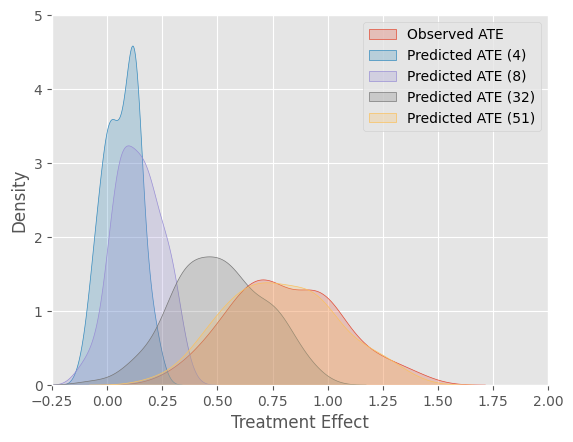

In [45]:
fig, ax = plt.subplots()
ax.set_xlabel('Treatment Effect')
ax.set_xlim(-0.25, 2)
ax.set_ylim(0, 5)
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
ax.legend()
fig.savefig('../presentation/sim_surrogacy_violation_1_0.png')
for n_surrogates in n_surrogate_list:
    sns.kdeplot(predicted_effects.loc[:, n_surrogates], label=f'Predicted ATE ({n_surrogates})', ax = ax, fill = True)
    ax.legend()
    fig.savefig(f'../presentation/sim_surrogacy_violation_1_{n_surrogates}.png')